# Section 1

https://github.com/calbal91/project-understanding-elections 

Some of the code and ideas are adapted and taken from the above GitHub Respository which focuses much on ML prediction rather than clustering. We have only extended the author's work on the clustering section. We hope this is useful for anyone interested in the UK politics domain.

###  Import packages & voting data 

In [2]:
#For data manipulation
import numpy as np
import pandas as pd
import json
import math

#For data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.font_manager
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set()
from matplotlib.pylab import rcParams

#For data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance


# Dimensionality Reduction
import umap
from sklearn.decomposition import PCA


#For clustering analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


#For evaluating clusters
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn import metrics


#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

#Allow ourselves to save things
import pickle

In [11]:
df_con = pd.read_csv('data_with_targets.csv') # Our base dataset
df_con.set_index('ID', inplace=True)
df = pd.read_csv('data_with_targets.csv') # We will use this dataset for feature engineering and preprocessing purposes

In [4]:
df_con.head(2)

,Constituency,Region,Type,Population,0-9,10-19,20-29,30-39,40-49,50-59,...,Depression,Obesity,Diabetes,Asthma,DiseasesPerPop,%LeaveVote,%17Turnout,Winner_17,seat_types_17,seat_types_yg
ID,,,,,,,,,,,,,,,,,,,,,
E14000554,Berwick-upon-Tweed,North East,Rural,75425,0.0863,0.0863,0.0902,0.1002,0.1102,0.1657,...,0.08551,0.13193,0.08029,0.07315,0.89389,0.553,0.719149,Con,con safe,con safe
E14000569,Bishop Auckland,North East,Rural,89415,0.1063,0.1086,0.1103,0.1090,0.1206,0.1533,...,0.12388,0.14646,0.08225,0.06856,0.89166,0.609,0.640827,Lab,con lab marginal,con lab marginal


### Define colour mappings and functions for later use

In [12]:
#Define colours for the visuals
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

CB91_BlueD = '#016794'
CB91_GreenD = '#187970'
CB91_PinkD = '#B317B1'
CB91_PurpleD = '#4E1762'
CB91_VioletD = '#330E4C'
CB91_AmberD = '#985E09'

CB91_BlueL = '#ABE5FF'
CB91_GreenL = '#B5F1EB'
CB91_PinkL = '#FAD9FA'
CB91_PurpleL = '#D9A8EB'
CB91_VioletL = '#ECD4F5'
CB91_AmberL = '#F9D094'


#The following gradients will be used for heatmaps, etc
CB91_Grad_BP = ['#2CBDFE', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

CB91_Grad_BA = ['#2cbdfe', '#31bdf9', '#36bcf5', '#3bbcf0',
                '#41bcec', '#46bbe7', '#4bbbe3', '#50bbde',
                '#55bbd9', '#5abad5', '#60bad0', '#65bacc',
                '#6ab9c7', '#6fb9c3', '#74b9be', '#79b8ba',
                '#7eb8b5', '#84b8b0', '#89b7ac', '#8eb7a7',
                '#93b7a3', '#98b79e', '#9db69a', '#a3b695',
                '#a8b690', '#adb58c', '#b2b587', '#b7b583',
                '#bcb47e', '#c1b47a', '#c7b475', '#ccb371',
                '#d1b36c', '#d6b367', '#dbb363', '#e0b25e',
                '#e6b25a', '#ebb255', '#f0b151', '#f5b14c']

CB91_Grad_AP = ['#f5b14c', '#f3ae4f', '#f0aa52', '#eea755',
                '#eca458', '#eaa05c', '#e79d5f', '#e59962',
                '#e39665', '#e19368', '#de8f6b', '#dc8c6e',
                '#da8971', '#d88574', '#d58277', '#d37f7b',
                '#d17b7e', '#cf7881', '#cc7584', '#ca7187',
                '#c86e8a', '#c66a8d', '#c36790', '#c16493',
                '#bf6096', '#bd5d9a', '#ba5a9d', '#b856a0',
                '#b653a3', '#b450a6', '#b14ca9', '#af49ac',
                '#ad46af', '#ab42b2', '#a83fb5', '#a63bb9',
                '#a438bc', '#a235bf', '#9f31c2', '#9d2ec5']

CB91_Grad_GP = ['#47dbcd', '#4bd9ce', '#50d8cf', '#54d6d0',
                '#59d5d1', '#5dd3d2', '#61d2d3', '#66d0d4',
                '#6acfd5', '#6fcdd6', '#73ccd6', '#78cad7',
                '#7cc9d8', '#80c7d9', '#85c6da', '#89c4db',
                '#8ec3dc', '#92c1dd', '#96c0de', '#9bbedf',
                '#9fbde0', '#a4bbe1', '#a8bae2', '#acb8e3',
                '#b1b7e4', '#b5b5e5', '#bab4e6', '#beb2e7',
                '#c2b1e8', '#c7afe9', '#cbaee9', '#d0acea',
                '#d4abeb', '#d9a9ec', '#dda8ed', '#e1a6ee',
                '#e6a5ef', '#eaa3f0', '#efa2f1', '#f3a0f2']

CB91_Grad_GWP= ['#47dbcd','#4fdcce','#56ddd0','#5dded1',
                '#64dfd2','#6ae0d3','#70e1d5','#75e2d6',
                '#7be3d7','#80e4d8','#85e5da','#8ae6db',
                '#8fe7dc','#94e8dd','#98e9df','#9deae0',
                '#a1ebe1','#a6ece2','#aaede4','#afede5',
                '#b3eee6','#b7efe8','#bbf0e9','#c0f1ea',
                '#c4f2eb','#c8f3ed','#ccf4ee','#d0f5ef',
                '#d4f6f1','#d8f6f2','#dcf7f3','#e0f8f5',
                '#e4f9f6','#e8faf7','#ecfbf8','#f0fcfa',
                '#f3fcfb','#f7fdfc','#fbfefe','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

CB91_Grad_BWP= ['#2cbdfe','#31bffe','#37c0fe','#3cc2fe',
                '#42c4fe','#47c5fe','#4cc7fe','#52c9fe',
                '#57cbfe','#5dccfe','#62cefe','#68d0fe',
                '#6dd1fe','#72d3fe','#78d5fe','#7dd6fe',
                '#83d8fe','#88dafe','#8ddbfe','#93ddfe',
                '#98dfff','#9ee1ff','#a3e2ff','#a8e4ff',
                '#aee6ff','#b3e7ff','#b9e9ff','#beebff',
                '#c3ecff','#c9eeff','#cef0ff','#d4f1ff',
                '#d9f3ff','#dff5ff','#e4f7ff','#e9f8ff',
                '#effaff','#f4fcff','#fafdff','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

#Add party colors
con_blue = '#0A3B7C'
lab_red = '#E4003B'
lib_yel = '#FAA61A'
snp_yel = '#FFF481'
green_green = '#52DF00'
brex_blue = '#00E2ED'
ukip_pur = '#470A65'
plaid_green = '#006A56'

con_lab = '#992281'
con_lib = '#837859'
con_snp = '#85987f'
lab_lib = '#ef532b'
lab_snp = '#f27a5e'
lib_snp = '#fccf4d'


#A list that we'll use to cycle through colors in charts
color_list = [CB91_Blue, CB91_Green, CB91_Amber, CB91_Pink,
              CB91_Violet, CB91_BlueD, CB91_GreenD, CB91_Purple,
              CB91_AmberL, CB91_BlueL, CB91_GreenL, CB91_AmberD, 
              CB91_VioletD, CB91_PinkL, CB91_VioletL, CB91_PinkD]

In [13]:
def cluster_IDs(cluster, cluster_data, cluster_col='Cluster'):
    
    '''
    Takes a cluster label (1, 2, 3, etc.) and a cluster dataframe,
    and returns a list of constituency IDs that belong to the given cluster
    '''
    return list(cluster_data.loc[cluster_data['Cluster']==cluster].index)



def cluster_kpi(kpi, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a given set of cluster labels, and a given KPI, returns a
    dataframe with one row, for that given kpi
    '''
    
    #Find the unique cluster labels
    cluster_labels = sorted(list(cluster_data[cluster_col].unique()))
    
    #Declare an empty list to store the KPI data in
    kpi_values = []
    
    #Iterate through the labels
    for i in cluster_labels:
        #Work out which constituencies are in the cluster
        cluster_index = cluster_IDs(cluster = i,
                                    cluster_data = cluster_data,
                                    cluster_col = cluster_col)
        
        #Go to the data table, and find the mean for that kpi
        #for those constituencies. Append to the list
        mean = data.loc[cluster_index, kpi].mean()
        kpi_values.append(mean)
        
    #Create and return a dataframe as required
    return pd.DataFrame([kpi_values],
                        columns = cluster_labels,
                        index = [kpi])



def cluster_kpis(kpis, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a list of KPIs, return a dataframe showing mean
    values on a cluster by cluster basis
    
    '''
    
    #Declare an empty dataframe
    df_temp = pd.DataFrame()
    
    #For each kpi, find the average cluster means, and append to the dataframe
    for i in kpis:
        cluster_values = cluster_kpi(kpi=i,
                                     data=data,
                                     cluster_data=cluster_data,
                                     cluster_col=cluster_col)
        
        df_temp = pd.concat([df_temp, cluster_values])
        
    return df_temp
        
        

def heatmap_cluster_kpis(kpis, data,
                       cluster_data,
                       size=0.4,
                       cmap=CB91_Grad_BP,
                       cluster_col='Cluster'):
    
    '''
    Heatmap the table produced by the cluster_kpis function
    '''
    
    #Calculate the required table and transpose
    df_temp = cluster_kpis(kpis=kpis,
                           data=data,
                           cluster_data=cluster_data,
                           cluster_col=cluster_col).T
    
    #For each kpi, scale as required
    scaler = MinMaxScaler()
    scaler.fit(df_temp)
    df_scale = scaler.transform(df_temp)
    
    df_scale = pd.DataFrame(df_scale,
                            columns=df_temp.columns,
                            index=df_temp.index)
    
    height = size*len(df_scale.index)
    width = 1.1*size*len(df_scale.columns)
    
    plt.figure(figsize=(width,height))
    sns.heatmap(df_scale,cbar=True,cmap=cmap)
    plt.yticks(rotation='horizontal')


#Use seaborn to set all the default chart visual settings
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":16})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [14]:
def gradient_mapper(kpi, grad, outliers=None, stretch=1, factor=1):
    
    '''
    Takes a list/series of numbers, outputs a list of hex colours,
    appropriate for heatmapping the initial data.
    
    Parameters:
    - col (list/series, etc.): The data to be transformed
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    
    '''
    #Work out how many colours we have in the given gradient
    colors = len(grad)
    half = colors // 2
    
    #Ensure that stretch is possible
    stretch = min(half//3, stretch)
    
    factors = [4*factor, 3*factor, 2*factor]
    
    if outliers != None:
        #Stretch gradient if required. Declare three lists:
        #Start is the stretch map for the bottom end
        if (outliers.lower() == 'bottom') or (outliers.lower() == 'both'):
            start = [factors[0]]*stretch + [factors[1]]*stretch + [factors[2]]*stretch
        else:
            start = []

        #End is the stretch map for the top end
        if (outliers.lower() == 'top') or (outliers.lower() == 'both'):
            end = [factors[2]]*stretch + [factors[1]]*stretch + [factors[0]]*stretch
        else:
            end = []

        #Middle is a list of 1s which will be non-transformed
        middle = [1 for i in range(colors - len(start) - len(end))]

        stretch_map = start + middle + end
        
    else:
        stretch_map = [1 for i in range(colors)]
        
    #Create tuples of the gradients, and the number of
    #times they should be repeated in the list
    zip_list = list(zip(grad,stretch_map))
    
    #Use this to create a list of lists
    #Each element will be a list of the same gradient
    #repeated the required number of times
    list_of_lists = [[i[0]]*i[1] for i in zip_list]
    
    #Melt this list of lists into a single list
    grad = sum(list_of_lists, [])
    
    #Re-define colors variable
    colors = len(grad)-1
    
    #Define the lowest and the highest points in the dataset
    kpi_min = kpi.min()
    kpi_max = kpi.max()
    
    #Transform the data to integers between zero and the length of the gradient list
    first_map = list(map(lambda x: int(round(colors*(x-kpi_min) /
                                             (kpi_max-kpi_min),0)), list(kpi)))
    
    #Map the integers onto the gradient list
    second_map = list(map(lambda x: grad[x], first_map))
    
    #Return this, as well as the new gradient
    return second_map, grad




f = open('constituencieshex.json')
datamap = json.load(f)
datamap = pd.DataFrame(datamap['hexes']).T
datamap = datamap[['n','q','r']]
datamap.columns=['Name','X','Y']

def kpi_map(kpi, width=6, colorbar=True,
            outliers=None, stretch=1, factor=1,
            exclude=[], title=None,
            colors=None, exc_color='#999999',
            grad=CB91_Grad_AP, data=df):
    
    '''
    Outputs a choropleth map, showing each constituency in the same size.
    
    Parameters:
    - kpi (list/series, etc.): The data to be transformed
    - width (float): The desired width of the figure
    - df (dataframe): The dataframe to get the data from
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    - exclude (list): A list of regions to exclude from the chart
    - colors (dataframe): A dataframe of hex-codes (index should be constituency codes)
    - title (string): The desired title of the chart
    
    '''    
    
    #Filter out different regions, depending on paramaters
    df_filtered = pd.concat([datamap, data[['Region',kpi]]], axis=1)
    
    #If we have colors to add, concatonate these in
    if isinstance(colors, pd.DataFrame):
        df_filtered = pd.concat([df_filtered, colors], axis=1)
        df_filtered.columns = ['Name', 'X', 'Y', 'Region', kpi, 'Colors']
    
    df_filtered = df_filtered.loc[~df_filtered['Region'].isin(exclude)]
    kpi_filtered = df_filtered[kpi]
    
    if isinstance(colors, pd.DataFrame) is False:
        #Use the gradient mapper function to return the colors for the plot
        gradient_map = gradient_mapper(kpi=kpi_filtered,
                                    grad=grad,
                                    outliers=outliers,
                                    stretch=stretch,
                                    factor=factor)
        colors_map = gradient_map[0]
    
    else:
        #Fill in nan colors with white
        df_filtered['Colors'].fillna(exc_color, inplace=True)
        
        #Return the column to be used as the colours list in the plot
        colors_map = list(df_filtered['Colors'])
    
    #Work out the aspect ratio of the filtered constituencies
    X_diff = np.max(df_filtered['X'])-np.min(df_filtered['X'])
    Y_diff = np.max(df_filtered['Y'])-np.min(df_filtered['Y'])
    
    #Declare the width and height of the plot
    height = width * (Y_diff/X_diff)
    size = 500*math.pi*((width/X_diff)**2)
    
    #Create the figure
    fig, ax = plt.subplots(figsize=(width,height))
    
    plt.xticks([])
    plt.yticks([])

    #Plot the scatter
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(df_filtered['X'],
                df_filtered['Y'],
                s=size,
                marker='s',
                c=colors_map)
    
    #Remove axes
    sns.despine(left=True, bottom=True)
    ax1.set_title(title);
    
    #plot the colorbar
    if (colorbar == True) and isinstance(colors, pd.DataFrame) is False:        
        cmap = LinearSegmentedColormap.from_list(name= '',
                                                 colors=gradient_map[1])
        ax2 = fig.add_subplot(2,30,28)
        norm = mpl.colors_map.Normalize(vmin=df_filtered[kpi].min(),
                                    vmax=df_filtered[kpi].max())
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                       norm=norm, orientation='vertical')
    
        # remove the x and y ticks
        for ax in [ax1,ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    else:
        ax1.set_xticks([])
        ax1.set_yticks([])

# Section 2

### Data preprocessing & Feature Engineering

In [16]:
df.head(2)

,ID,Constituency,Region,Type,Population,0-9,10-19,20-29,30-39,40-49,...,Depression,Obesity,Diabetes,Asthma,DiseasesPerPop,%LeaveVote,%17Turnout,Winner_17,seat_types_17,seat_types_yg
0,E14000554,Berwick-upon-Tweed,North East,Rural,75425,0.0863,0.0863,0.0902,0.1002,0.1102,...,0.08551,0.13193,0.08029,0.07315,0.89389,0.553,0.719149,Con,con safe,con safe
1,E14000569,Bishop Auckland,North East,Rural,89415,0.1063,0.1086,0.1103,0.1090,0.1206,...,0.12388,0.14646,0.08225,0.06856,0.89166,0.609,0.640827,Lab,con lab marginal,con lab marginal


In [17]:
# We first remove the Northern Ireland Region and Chorley seat (Speaker Seat) since these will cause outliers
df = df.loc[(df['Region'] != 'Northern Ireland')
           &(df['Constituency'] != 'Chorley')]

# Copy the data so you can use later if needed
data = df.copy()

# Remove constituency, type, and region column as we do not any geographic location data to affect our clustering
df = df.iloc[:, 4:]

# Reduce the ranges of the age columns
# Looking at all the age columns, it is best to combine some of them say above 60 category as the more older a person gets, 
# it maybe that he does not even vote or separating ages into such narrow categories does not seem to produce much benefit. 
# So our proposed categories would be (0-19) (how many kids/teenagers a household has, going uni etc), (20-29) 
# would involve uni,
# marriage, work life etc, (30-59) would include mainly parents, adulthood, maturity, richer category compared 
# to other categories, 60-80+ would represent old age categories.
# df['0-19%'] = df.iloc[:, 1] + df.iloc[:, 2]
df['0-9'] = df.iloc[:, 1] + df.iloc[:, 2]
df.rename(columns={'0-9': '0-19%'}, inplace=True)
df.drop(columns=['10-19'], inplace=True)

df['30-39'] = df['30-39'] + df['40-49'] + df['50-59']
df.rename(columns={'30-39': '30-59%'}, inplace=True)
df.rename(columns={'20-29': '20-29%'}, inplace=True)

df.drop(columns=['40-49', '50-59'], inplace=True)
df['60-69'] = df['60-69'] + df['70-79'] + df['80+']
df.rename(columns={'60-69': '60+%'}, inplace=True)
df.drop(columns=['70-79', '80+'], inplace=True)

# We will restrict born regions to 'Born UK', 'Born Asia', 'Born Other Europe', 'Born Rest of the World' which can 
# signficantly better focus target campaigns of different political parties as to target even more than 3 ethnicities
# does require lot of effort.

# With regards to religion, we can use the top 3-4 categories of religion according to wikipedia which would be Christianity, 
# Islam, No religion or atheism and Hinduisim. There are 7 categories in the current dataframe and targeting all these religions
# specifically would not be very effective. We will restrict to 4 categories specifically: Islam, Christianity, No religion and 
# other religion

# Born UK and being Christian is highly correlated or being white and christian or being south asian and muslim. 
# As our focus on predicting clusters rather than interpreting the parameters obtained, having such intercorrelation 
# issues should not be an issue.

# Lastly, concerning race colour, I believe the 4 mentioned (White, Black, Asian, Mixed) are sufficient to be used 
# for our clustering algorithms

# Country of Birth
df['%BornSouthAsia'] = df['%BornSouthAsia'] + df['%BornSEAsia'] + df['%BornEastAsia']
df.rename(columns={'%BornSouthAsia': '%Born_Asia'}, inplace=True)
df.drop(columns=['%BornSEAsia', '%BornEastAsia'], inplace=True)

df['%BornIreland'] = df['%BornIreland'] + df['%BornOtherEU'] + df['%BornOtherEurope']
df.rename(columns={'%BornIreland': '%Born_Other_Europe'}, inplace=True)
df.drop(columns=['%BornOtherEU', '%BornOtherEurope'], inplace=True)


df['%BornAfrica'] = df['%BornAfrica'] + df['%BornME'] + df['%BornNAmerica'] + df['%BornLatinAmerica'] + df['%BornAustralasia']
df.rename(columns={'%BornAfrica': '%Born_RestOf_theWorld'}, inplace=True)
df.drop(columns=['%BornME', '%BornNAmerica', '%BornLatinAmerica', '%BornAustralasia'], inplace=True)


# Religion
df['%Sikh'] = df['%Sikh'] + df['%Hindu'] + df['%Buddhist'] + df['%Jewish']
df.rename(columns={'%Sikh': '%Other_Religion'}, inplace=True)
df.drop(columns=['%Hindu', '%Jewish', '%Buddhist'], inplace=True)


# Obtain only the Great Britian dataset by droppping all columns which have NAs
# When we drop all columns with NAs, we keep rows with constituencies being from Scotland and Wales 
# as these constituencies cause the NAs mainly. 
# When we drop all rows with NAs, automatically these constituencies are removed

df_gb = df.dropna(axis=1)

In [18]:
df_gb = pd.read_csv('data_gb.csv', index_col='ID')

# Apply log transformations to reduce skewness in the data for dimensionality reduction
df_gb[['AreaKM2', 'Pop_Density','Businesses', 'BusinessesPer1kCap','2019_Wage', 'HousePrice', 
       'HousePricePerWage']].apply(np.log1p, inplace=True)

# GB Dataset
X_gb = df_gb.iloc[:,:-3]
y17_gb = df_gb['Winner_17']
y17_st_gb = df_gb['seat_types_17']
y19_st_gb = df_gb['seat_types_yg'] # You Gov



# Add percentages of seats won by the conservative, labour, liberal, Scottish and Green party in every constituency
df_election = pd.read_csv('HoC-GE2017-constituency-results.csv', index_col='ons_id')
df_election.drop(columns=['ons_region_id', 'constituency_name', 'county_name', 'region_name',
       'country_name', 'constituency_type', 'declaration_time', 'result',
       'first_party', 'second_party', 'electorate'], inplace=True)

df_election.drop(columns=['invalid_votes', 'dup', 'sdlp', 'uup',
       'alliance', 'other', 'other_winner'], inplace=True)

df_election['con%'] = (df_election['con'] / df_election['valid_votes']) * 100
df_election['lab%'] = (df_election['lab'] / df_election['valid_votes']) * 100
df_election['ld%'] = (df_election['ld'] / df_election['valid_votes']) * 100
df_election['snp%'] = (df_election['snp'] / df_election['valid_votes']) * 100
df_election['green%'] = (df_election['green'] / df_election['valid_votes']) * 100
df_election.index.names = ['ID']

# Merge the two datasets together
# We will work with two datasets at the end - one with the % of snp votes included and the other without
# This is so we can analyze the clusters we get based on either including or excluding the column
X_gb_with_snp = pd.concat([X_gb, df_election[['con%','lab%','ld%','snp%']]], axis=1, join='inner')

X_gb_without_snp = pd.concat([X_gb, df_election[['con%','lab%','ld%']]], axis=1, join='inner')

### Scaling & Dimensionality Reduction

In [19]:
# With SNP Votes
scaler = StandardScaler()
X_gb_scaled_snp = scaler.fit_transform(X_gb_with_snp)

# Without SNP Votes
scaler = StandardScaler()
X_gb_scaled_without_snp = scaler.fit_transform(X_gb_without_snp)

In [21]:
X_gb_scaled_snp.shape

(631, 57)

### PCA

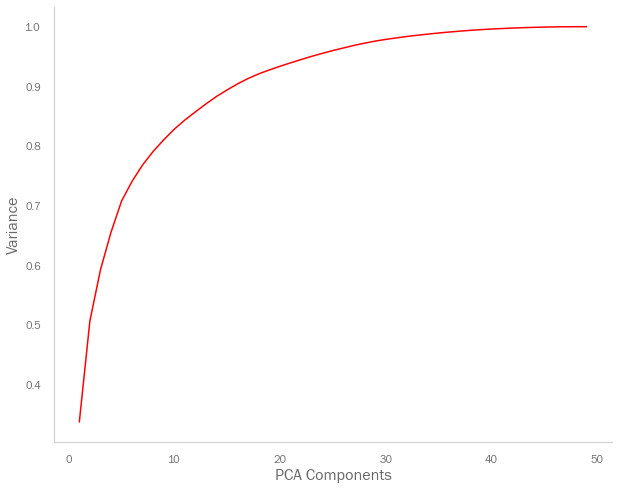

,model,var
n,,
49,PCA(n_components=49),0.999926
48,PCA(n_components=48),0.999877
47,PCA(n_components=47),0.999767
46,PCA(n_components=46),0.999578
45,PCA(n_components=45),0.999269
44,PCA(n_components=44),0.998798
43,PCA(n_components=43),0.998268
42,PCA(n_components=42),0.997622
41,PCA(n_components=41),0.996834


In [20]:
# log columns
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 50):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X_gb_scaled_without_snp) # has 86 features
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')


plt.figure(figsize=(10,8))
sns.lineplot(x='n', y='var', data=pca_df, color='red')
plt.xlabel('PCA Components')
plt.ylabel('Variance')
plt.show()


pca_df.sort_values(by='var', ascending=False).head(30)

In [22]:
# We will try to have 30 components as it preserves at least 97% and reduces the dimensionality significantly (from 56/57) --> 
# 30

In [23]:
PCAmod = PCA(n_components=30)
PCAmod.fit(X_gb_scaled_snp)
PCA_df_gb = pd.DataFrame(PCAmod.transform(X_gb_scaled_snp))


PCAmod = PCA(n_components=30)
PCAmod.fit(X_gb_scaled_without_snp)
PCA_df_gb_without_snp = pd.DataFrame(PCAmod.transform(X_gb_scaled_without_snp))

### UMAP

In [24]:
# For fair comparison, we will select the number of components from UMAP (Non-Linear) as we did with PCA i.e., 30 components
umap_c = umap.UMAP(n_components=30, metric='euclidean' , init='random', random_state=0)
umap_df = umap_c.fit_transform(X_gb_scaled_snp)

umap_c = umap.UMAP(n_components=30, metric='euclidean' , init='random', random_state=0)
umap_df_without_snp = umap_c.fit_transform(X_gb_scaled_without_snp)

# Section 3

### Functions for visualizations

In [25]:
# Define all the UK political parties and their colours we will use for later in our visualizations 

party_list = ['con safe','con lab marginal',
'lab safe','ld safe',
'con ld marginal','lab ld marginal',
'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']


party_colors = [con_blue, con_lab, lab_red, lib_yel,con_lib, lab_lib, 
                green_green, con_snp, snp_yel, lib_snp]

In [125]:
# Metric Visuals

def elbow_visuals(metr, model, data):
    if str(metr) == 'Distortion':
        visualizer = KElbowVisualizer(model, k=(2,18), timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
    elif str(metr) == 'Calinski':
        visualizer = KElbowVisualizer(model, k=(2,18), metric='calinski_harabasz', timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
    elif str(metr) == 'Silhouette':
        visualizer = KElbowVisualizer(model, k=(2,18), metric='silhouette', timings= True)
        visualizer.fit(data)        # Fit data to visualizer
        visualizer.show()  
        
# Dendogram for Heirarchical Clustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy


def dendro_hac(model, data):
    
    m = model.fit(data)
    Z = hierarchy.linkage(m.children_, 'ward')
    plt.figure(figsize=(20,10))
    plt.title("Dendrograms") 
    dn=hierarchy.dendrogram(Z)



def Davies_Bouldin_Viz(model, data):
    
    # Davies Bouldin Score
    # Davies Bouldin Index - need at least 2 points in each cluster
    # As DB Index falls, clustering improves
    # Davies Bouldin score for K means
    
    scores = []
    p = []
    centers = range(2, 20)
    
    if model == 'KMeans':
        
        for i in list(centers):
            kmeans = KMeans(n_clusters=i)
            m = kmeans.fit_predict(data)
            score = davies_bouldin_score(data, m)
            scores.append(score)
            p.append((i, score))
            
    if model == 'HAC':
        
        for i in list(centers):
            hac = AgglomerativeClustering(n_clusters=i)
            m = hac.fit_predict(data)
            score = davies_bouldin_score(data, m)
            scores.append(score)
            p.append((i, score))
            
#     display(round(pd.DataFrame(p)[1]), 4)
#     print(round(min(scores), 4))
    sns.lineplot(list(centers), scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('Davies Bouldin score');
    plt.title('Davies Bouldin score vs. K');
    
    df = pd.DataFrame(p)[round(pd.DataFrame(p)[1], 3) == round(min(scores), 3)]
    df.columns = ['# Clusters', 'Davies_Bouldin_Score']
    return df




    
# Heatmap function

def kpi_heatmap(kpi_data, data, snp=True):
    
    if snp == True:

        heatmap_cluster_kpis(kpis=kpi_data,data=X_gb_with_snp,cmap='coolwarm_r',size=0.7, cluster_data=data)
        plt.title('Heatmap of English Constituency Clusters by KPI\n\
        (0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
        plt.ylabel('Cluster Number')
        
    if snp == False:
        
        heatmap_cluster_kpis(kpis=kpi_data,data=X_gb_without_snp ,cmap='coolwarm_r',size=0.7, cluster_data=data)
        plt.title('Heatmap of English Constituency Clusters by KPI\n\
        (0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
        plt.ylabel('Cluster Number') 
        
    
    
def Map_cluster(data):
    kpi_map('Population',colors=data[['Colors']], data=df_con,
    exc_color='#ffffff',exclude=['Northern Ireland'], width=11)
    

def cluster_bar_visual(data):

    gb_cluster_bar = (data/ data.sum()).T.sort_values(by='lab safe', ascending=True)

    gb_cluster_bar.plot.barh(stacked=True,
                  figsize=(12,5),
                  width=0.8,
                  color=party_colors)

    plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
    plt.xlim(0,1);

    plt.title('GB Constituency Clusters');
    plt.ylabel('Cluster Number')

    plt.legend(bbox_to_anchor=(0.85, -0.1),
                   ncol=4,frameon=False)
    
    
def clustering_metrics(model, data, clust=None): # yhat = model.fit(data)
    
    if clust == 'BIC':
        model.fit(data)
        model2 = model.predict(data)
        score_AGclustering_s = silhouette_score(data, model2, metric='euclidean')
        score_AGclustering_c = calinski_harabasz_score(data, model2)
        score_AGclustering_d = davies_bouldin_score(data, model2)
        
    else:
    
        yhat = model.fit(data)
        yhat_2 = model.fit_predict(data)

        # retrieve unique clusters
        # Calculate cluster validation metrics
        score_AGclustering_s = silhouette_score(data, yhat.labels_, metric='euclidean')
        score_AGclustering_c = calinski_harabasz_score(data, yhat.labels_)
        score_AGclustering_d = davies_bouldin_score(data, yhat_2)
    

    print('Silhouette Score: %.4f' % score_AGclustering_s)
    print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
    print('Davies Bouldin Score: %.4f' % score_AGclustering_d)  
    
    
def cluster_dataframes(preds):
    
    gb_cluster_yg = pd.concat([y19_st_gb,
                       pd.DataFrame(preds[0],
                                    index=y17_st_gb.index,
                                    columns=['Cluster'])],
                       axis=1)

    gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                             index='seat_types_yg',
                                             columns='Cluster',
                                             aggfunc=len,
                                             fill_value=0)
    
    gb_cluster_yg_pivot = gb_cluster_yg_pivot.reindex(party_list)
    
    return gb_cluster_yg, gb_cluster_yg_pivot

### Define all the clustering algorithms to all be used in Section 4

In [126]:
# Clustering Algorithms

def K_Means(n_clusters, data):
    
    k_means = KMeans(n_clusters)
    k_means.fit(data)

    #Store the predicted labels
    km_preds_gb = []
    km_preds_gb.append(k_means.predict(data))
    
    clustering_metrics(k_means, data)
    
    return km_preds_gb
    


def HAC(n_clusters, data):
    
    #Instantiate and run a HAC algorithm
    HAC = AgglomerativeClustering(n_clusters)

    #Store the predicted labels
    hac_preds_gb = []
    hac_preds_gb.append(HAC.fit_predict(data))
    clustering_metrics(HAC, data)
    
    return hac_preds_gb

def DB_Clustering(ep, min_points, alg, data):
    
    db = DBSCAN(eps=float(ep), min_samples=float(min_points), algorithm=str(alg))
    #Store the predicted labels
    db_preds_gb = []
    preds = db.fit_predict(data)
    db_preds_gb.append(preds)
    clustering_metrics(db, data)
    
    # Fit the models
    clm46 = db.fit(data)
    # Print DBSCAN results
    print('*************** DBSCAN Clustering Model ***************')
    print("Cluster labels")
    print(np.unique(clm46.labels_))
    
    return db_preds_gb 


def Mean_Shift(b, data):
    
    ms = MeanShift(bandwidth=float(b)) 
    ms.fit(data)

    yhat = ms.predict(data)

    ms_preds_gb = []
    #Store the predicted labels
    ms_preds_gb.append(yhat)
    
    clustering_metrics(ms, data)
    
    return ms_preds_gb

def GMM(n_comp, covar, data):
    
    gmm = GaussianMixture(n_components=int(n_comp),covariance_type=str(covar), random_state = 100)
    gmm_preds_gb = []
    gmm.fit(data)
    preds = gmm.predict(data)
    clustering_metrics(gmm, data, clust = 'BIC')
    gmm_preds_gb.append(preds)
    
    return gmm_preds_gb

# Finalize the data function
# We will output this with our main function at the very end --> Section 4
def constituency_clusters(cluster_df, data):      
    dframe = pd.concat([data, cluster_df], join='inner', axis=1)[['Constituency', 'seat_types_yg', 'Colors', 'Cluster']]
    dframe = dframe.loc[:,~dframe.columns.duplicated()].reset_index()

    return dframe

In [129]:
def DBScan_func(dim_red, metric, data):

    score = []
    # Define ranges to explore
    eps_range=range(3, 11)  
    minpts_range=range(3,11)
    
    for k in eps_range:
        for j in minpts_range:
            for x in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            
                if str(dim_red) == 'PCA':
                    model = DBSCAN(eps=k, min_samples=j, algorithm=x)
                    clm = model.fit(data)
                    score_d = metrics.davies_bouldin_score(data, clm.labels_)
                    score_s = metrics.silhouette_score(data, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(data, clm.labels_)
                    score.append((k, j, score_d, score_s, score_h, x))

                elif str(dim_red) == 'UMAP':
                    model = DBSCAN(eps=k/10, min_samples=j)
                    clm = model.fit(data)
                    score_d = metrics.davies_bouldin_score(data, clm.labels_)
                    score_s = metrics.silhouette_score(data, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(data, clm.labels_)
                    score.append((k/10, j, score_d, score_s, score_h, x))
                
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Epsilon', 'Minimum_points', 'Davies_Bouldin_Score', 'Silhouette_Score', 'Calinski_Harabasz', 'Algorithm']
    
    if str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()] 
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz == score_1.Calinski_Harabasz.max()]
    
    return score_2.head(2)


def Gaussian_MM_metrics(dim_red, metric, data):
    
        
    score = []
    n_components = range(2, 20)
    covariance_type = ['spherical', 'tied', 'diag', 'full']
    
    for cov in covariance_type:
        for n_comp in n_components:
            gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state=101, reg_covar=1e-04)
            gmm.fit(data)
            model2 = gmm.predict(data)
            Calin  = calinski_harabasz_score(data, model2)
            Silh   = silhouette_score(data, model2) 
            Davies = davies_bouldin_score(data, model2)
            score.append((cov,n_comp, gmm.bic(data), Calin, Silh, Davies))
            
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Covariance_Type', 'N_Components', 'BIC_Score', 'Calinski_Harabasz_Score', \
                       'Silhouette_Score', 'Davies_Bouldin_Score']
    
        
    if str(metric) == 'BIC':
        score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]
        
    elif str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]      
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
        
    return score_2.head(2)


def Mean_Shift_metrics(dim_red, metric, data):
    
    if str(dim_red) == 'PCA':
        bandwidths = range(2, 11)
    elif str(dim_red) == 'UMAP':
        bandwidths = np.round(np.linspace(0.2, 1.2, 11), 2)
            
    score = []

    for b in bandwidths:
        ms = MeanShift(bandwidth=b)
        model = ms.fit(data)
        model_2 = model.predict(data)
        score_c = calinski_harabasz_score(data, model_2)
        score_d = davies_bouldin_score(data, model_2)
        score_s = silhouette_score(data, model_2, metric='euclidean')
        
        score.append((b, score_c, score_d, score_s))
        
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Bandwidth', 'Calinski_Harabasz_Score', 'Davies_Bouldin_Score', 'Silhouette_Score']
    
    if str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]      
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
        
    else:
        print('Try again!')
        
    return score_2.head(2)

# Section 4 - Final

### Our main function 

In [130]:
def WDSS_clustering(data, dim_reduction, clustering_method, metric_visuals=False, map_plot=False, cluster_bar=False,
                   metric=None, heatmap=False, dendrogram=False, snp_included=True):
 # K-Means:   
    
    if clustering_method == 'KMeans':
        model = KMeans()
      
        if dim_reduction == 'PCA':
            if snp_included == False:
                data_main = PCA_df_gb_without_snp
            else:
                data_main = PCA_df_gb
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
                if metr == 'Davies Bouldin':
                    display(Davies_Bouldin_Viz(clustering_method, data_main))
                else:
                    elbow_visuals(metr, model, data_main)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = K_Means(n_clust, data_main)
            
        elif dim_reduction == 'UMAP':
            if snp_included == False:
                data_main = umap_df_without_snp
            else:
                data_main = umap_df
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
                if metr == 'Davies Bouldin':
                    display(Davies_Bouldin_Viz(clustering_method, data_main))
                else:
                    elbow_visuals(metr, model, data_main)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = K_Means(n_clust, data_main)
            
     # HAC: 
    elif clustering_method == 'HAC':
        model = AgglomerativeClustering()
        
        if dim_reduction == 'PCA':
            if snp_included == False:
                data_main = PCA_df_gb_without_snp
            else:
                data_main = PCA_df_gb
            if metric_visuals == True:
                metr = input("Please input from the visuals of your choice ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
                if metr == 'Davies Bouldin':
                    display(Davies_Bouldin_Viz(clustering_method, data_main))
                else:
                    elbow_visuals(metr, model, data_main)
                    
            if dendrogram == True:
                dendro_hac(model, data_main)
                     
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = HAC(n_clust, data_main)
            
        elif dim_reduction == 'UMAP':
            if snp_included == False:
                data_main = umap_df_without_snp
            else:
                data_main = umap_df
                
            if metric_visuals == True:
                metr = input("Please input from the visuals of your choice ['Distortion', 'Silhouette', 'Calinski', 'Davies Bouldin']: ")
                if metr == 'Davies Bouldin':
                    display(Davies_Bouldin_Viz(clustering_method, data_main))
                else:
                    elbow_visuals(metr, model, data_main)
            if dendrogram == True:
                dendro_hac(model, data_main)
                    
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = HAC(n_clust, data_main)
            
            
     # DB Scan:
    elif clustering_method == 'DBScan':  
        if dim_reduction == 'PCA':
            if snp_included == False:
                data_main = PCA_df_gb_without_snp
            else:
                data_main = PCA_df_gb
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(DBScan_func('PCA', metr, data_main))

            ep = input("Enter epsilon value from 3 or above: ")
            mns = input("Enter minimum samples value from 3 or above: ")
            algo = input("Enter algorithm type from the list: [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]: ")
            preds_gb = DB_Clustering(ep, mns, algo, data_main)
            
            
        elif dim_reduction == 'UMAP':
            
            if snp_included == False:
                data_main = umap_df_without_snp
            else:
                data_main = umap_df
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(DBScan_func('UMAP', metr, data_main))

            ep = input("Enter epsilon value from 0.3 or above: ")
            mns = input("Enter minimum samples value from 3 or above: ")
            algo = input("Enter algorithm type from the list: [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]: ")
            preds_gb = DB_Clustering(ep, mns, algo, data_main)
            
     # GMM:
            
    elif clustering_method == 'GMM':
        if dim_reduction == 'PCA':
            if snp_included == False:
                data_main = PCA_df_gb_without_snp
            else:
                data_main = PCA_df_gb
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['BIC', 'Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(Gaussian_MM_metrics('PCA', metr, data_main))
                
            n_compon = input("Enter number of components/clusters for GMM: ")
            covar = input("Enter the covariance type for GMM: ")
            preds_gb = GMM(n_compon, str(covar), data_main)
            
        elif dim_reduction == 'UMAP':
            
            if snp_included == False:
                data_main = umap_df_without_snp
            else:
                data_main = umap_df
                
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['BIC', 'Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(Gaussian_MM_metrics('UMAP', metr, data_main))
                
            n_compon = input("Enter number of components/clusters for GMM: ")
            covar = input("Enter the covariance type for GMM: ")
            preds_gb = GMM(n_compon, str(covar), data_main)
            
     # Mean Shift
            
    elif clustering_method == 'MS':
        if dim_reduction == 'PCA':
            if snp_included == False:
                data_main = PCA_df_gb_without_snp
            else:
                data_main = PCA_df_gb
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(Mean_Shift_metrics(dim_reduction, metr, data_main))
                
            b = input("Enter bandwidth for Mean Shift: ")
            preds_gb = Mean_Shift(b, data_main)
            
        elif dim_reduction == 'UMAP':
            
            if snp_included == False:
                data_main = umap_df_without_snp
            else:
                data_main = umap_df
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(Mean_Shift_metrics(dim_reduction, metr, data_main))
                
            b = input("Enter bandwidth for Mean Shift: ")
            preds_gb = Mean_Shift(b, data_main)
        
        
            
    gb_cluster_yg, gb_cluster_yg_pivot = cluster_dataframes(preds_gb)
    
    if len(np.unique(gb_cluster_yg['Cluster'])) >= 16:
        print("Too many clusters to show - reduce clusters from the current {} clusters".format(len(np.unique(gb_cluster_yg['Cluster']))))

        return gb_cluster_yg
    
    else:


        if cluster_bar == True:
            cluster_bar_visual(gb_cluster_yg_pivot)
    
        
        gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(lambda x: color_list[x])

        if map_plot == True:
            Map_cluster(gb_cluster_yg)

        df = constituency_clusters(gb_cluster_yg, data)


        #Define a standard list of KPIs to look at

        if heatmap == True:
            if snp_included == True:

                kpis_gb = ['Pop_Density','2019_Wage', 'HousePricePerWage', '%HousePriceGrowth','%OwnOutright','%OwnWithMort',
                      '%PrivateRent','%SocialHousing','%Unemployment', 'UnemploymentChange',
                      '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
                      '%FS & ICT', '%White', '%Muslim', '%BornUK','%Level4+', '%LeaveVote', 'con%', 'snp%', 'lab%']

                kpi_heatmap(kpis_gb, gb_cluster_yg)
                
            elif snp_included == False:
                kpis_gb = ['Pop_Density','2019_Wage', 'HousePricePerWage', '%HousePriceGrowth','%OwnOutright','%OwnWithMort',
                '%PrivateRent','%SocialHousing','%Unemployment', 'UnemploymentChange',
                '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
                '%FS & ICT', '%White', '%Muslim', '%BornUK','%Level4+', '%LeaveVote', 'con%', 'ld%', 'lab%']

                kpi_heatmap(kpis_gb, gb_cluster_yg, snp=False)
        
        return df

Please input the metric of your choice from ['BIC', 'Davies Bouldin', 'Silhouette', 'Calinski']: BIC


,Covariance_Type,N_Components,BIC_Score,Calinski_Harabasz_Score,Silhouette_Score,Davies_Bouldin_Score
55,full,3,44024.127979,134.171383,0.123787,1.936654


Enter number of components/clusters for GMM: 3
Enter the covariance type for GMM: full
Silhouette Score: 0.1243
Calinski Harabasz Score: 134.5750
Davies Bouldin Score: 1.9323


,ID,Constituency,seat_types_yg,Colors,Cluster
0,E14000554,Berwick-upon-Tweed,con safe,#2CBDFE,0
1,E14000569,Bishop Auckland,con lab marginal,#2CBDFE,0
2,E14000574,Blaydon,lab safe,#2CBDFE,0
3,E14000575,Blyth Valley,con lab marginal,#F5B14C,2
4,E14000641,City of Durham,con lab marginal,#F5B14C,2
5,E14000658,Darlington,con lab marginal,#F5B14C,2
6,E14000677,Easington,lab safe,#F5B14C,2
7,E14000709,Gateshead,lab safe,#F5B14C,2
8,E14000733,Hartlepool,con lab marginal,#F5B14C,2
9,E14000746,Hexham,con safe,#2CBDFE,0


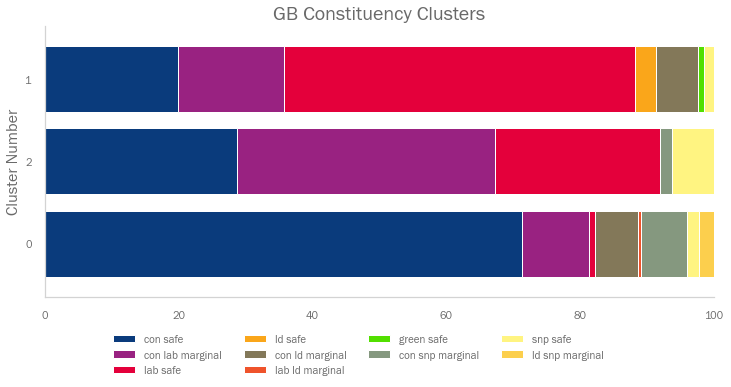

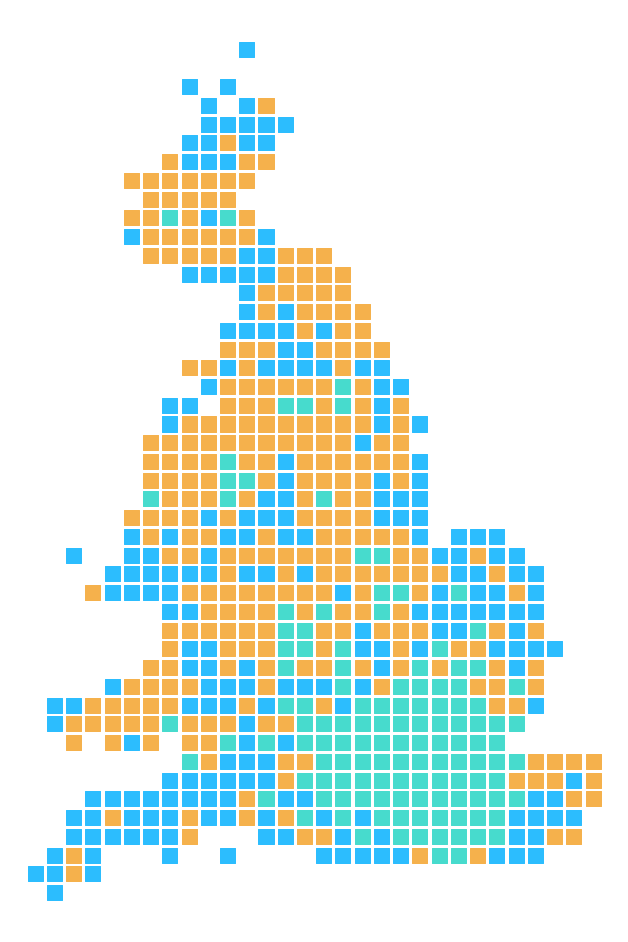

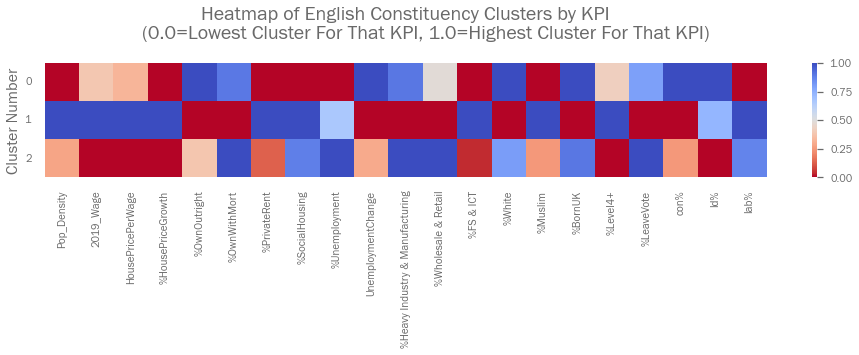

In [131]:
# Clustering Methods: HAC, KMeans, DBScan, GMM, MS
dat = WDSS_clustering(data=df_con, dim_reduction='PCA', clustering_method='GMM', map_plot=True, metric_visuals=True,
                     cluster_bar=True, heatmap=True, dendrogram=False, snp_included=True)
dat.head(10)

In [59]:
# If we choose to save a dataset with a particular clustering:

# dat.to_csv('YYY.csv')

### Insights

When we use UMAP and clustering algorithms like KMeans and HAC, if we include snp votes, we get mainly 2 clusters based on the Davies Bouldin and Silhouette metrics which are Scotland and non-Scotland regions. 

Similarly, if we replace UMAP with PCA, we also get 2 clusters but this time, it is either london or non-london regions. This is due to PCA being affected easily by the huge difference london has with other regions. UMAP is more effective in detecting non-linear patterns and more sophisticated clusterings for example Scottish or non-Scottish

As can be seen in the heatmap, conservative areas tend to be more white, indigenous, have low unemployment, mostly are better off than labour clusters for example